In [73]:
import numpy as np
import matplotlib.pyplot as plt

import networkx as nx
from networkx.algorithms import community

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.datasets import make_blobs

from pecanpy import node2vec
from gensim.models import Word2Vec
from gensim.models.callbacks import CallbackAny2Vec

from time import time

https://towardsdatascience.com/run-node2vec-faster-with-less-memory-using-pecanpy-1bdf31f136de

https://towardsdatascience.com/overview-of-deep-learning-on-graph-embeddings-4305c10ad4a4

https://towardsdatascience.com/node2vec-explained-graphically-749e49b7eb6b

https://intel.github.io/scikit-learn-intelex/

In [2]:
# Load the graph    
G = nx.read_edgelist('../Data/coauthorship.edgelist', delimiter=' ', nodetype=int)

### Walk generation

In [3]:
# Loads graph and generate walks
g = node2vec.SparseOTF(p=0.5, q=1, workers=4, verbose=True)
g.read_edg('../Data/coauthorship_tab.edgelist', weighted=False, directed=False)
print("Loaded graph\n")
walks = g.simulate_walks(num_walks = 10, walk_length = 10, n_ckpts = 100, pb_len = 100)
print("Generated walks")

Loaded graph

100%|███████████████████████████████████████████████████████████████████| 2178010.0/2178010 [00:46<00:00, 46380.59it/s]
Generated walks


### word2vec embedding

In [4]:
class EpochLogger(CallbackAny2Vec):
    '''Callback to report progress'''
    def __init__(self):
        self.epoch = 0
        self.t0 = time()
    def on_epoch_begin(self, model):
        print("\nEpoch #{} start".format(self.epoch))
        self.t0 = time()
    def on_epoch_end(self, model):
        print("Epoch #{} end".format(self.epoch))
        print("Duration of epoch: {:.2}".format(time() - self.t0))
        self.epoch += 1

In [5]:
# Builds the word2vec embedding based on the previously computed walks

n_dim = 200
epoch_logger = EpochLogger()

model = Word2Vec(vector_size = n_dim, window = 8, min_count = 0, sg = 1, workers = 4, hs = 1)
print("Built model")
model.build_vocab(walks)
print("\nBuilt vocabulary")
model.train(walks, total_examples=model.corpus_count, epochs=5, callbacks = [epoch_logger])
print("\nTrained model")

Built model

Built vocabulary

Epoch #0 start
Epoch #0 end
Duration of epoch: 4.9e+02

Epoch #1 start
Epoch #1 end
Duration of epoch: 4.2e+02

Epoch #2 start
Epoch #2 end
Duration of epoch: 3.6e+02

Epoch #3 start
Epoch #3 end
Duration of epoch: 3.5e+02

Epoch #4 start
Epoch #4 end
Duration of epoch: 3.6e+02

Trained model


In [66]:
# Save the model for reusing later
model.save("../Word2Vec_models/model1.model")

In [6]:
embedding = np.zeros((G.number_of_nodes(), n_dim))

for idx, node in enumerate(G.nodes()):
    embedding[idx, :] = model.wv[str(node)]

### k-means clustering

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19



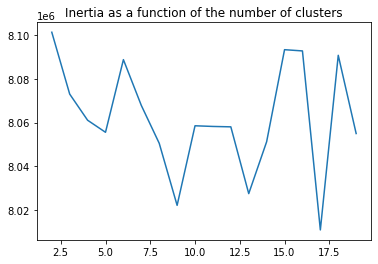

In [67]:
# Choose the good number of cluster by comparing kmeans.inertia_ for different n_cluster

lk = []
l_inertia = []

for k in range(2, 20):
    print(k)
    best_kmeans = None
    best_inertia = np.inf
    for _ in range(5):
        kmeans = MiniBatchKMeans(n_clusters = 5)
        kmeans.fit(embedding)
        if best_inertia > kmeans.inertia_:
            best_kmeans = kmeans
            best_inertia = kmeans.inertia_
    kmeans = best_kmeans
    lk.append(k)
    l_inertia.append(kmeans.inertia_)

plt.plot(lk, l_inertia)
plt.title("Inertia as a function of the number of clusters")
print()

In [68]:
#kmeans = KMeans(n_clusters = 5)

# MiniBatchKmeans does not do multiple restarts so we do it manually
best_kmeans = None
best_inertia = np.inf
for _ in range(1):
    kmeans = MiniBatchKMeans(n_clusters = 5, verbose = True)
    kmeans.fit(embedding)
    print(kmeans.inertia_)
    if best_inertia > kmeans.inertia_:
        best_kmeans = kmeans
        best_inertia = kmeans.inertia_
kmeans = best_kmeans

# The array indicating the cluster of each node
clusters = kmeans.labels_

Init 1/3 with method k-means++
Inertia for init 1/3: 171075.73483177443
Init 2/3 with method k-means++
Inertia for init 2/3: 160742.61901652906
Init 3/3 with method k-means++
Inertia for init 3/3: 168264.78064141521
[MiniBatchKMeans] Reassigning 2 cluster centers.
Minibatch step 1/21269: mean batch inertia: 52.50992871305528
Minibatch step 2/21269: mean batch inertia: 37.277097404653745, ewa inertia: 37.277097404653745
Minibatch step 3/21269: mean batch inertia: 37.24292981169722, ewa inertia: 37.2767761255545
[MiniBatchKMeans] Reassigning 2 cluster centers.
Minibatch step 4/21269: mean batch inertia: 38.00089557195774, ewa inertia: 37.283585046621496
Minibatch step 5/21269: mean batch inertia: 36.884415286387764, ewa inertia: 37.279831639081806
Minibatch step 6/21269: mean batch inertia: 37.44993411802814, ewa inertia: 37.281431118778414
Minibatch step 7/21269: mean batch inertia: 37.03320326129948, ewa inertia: 37.27909702335175
Minibatch step 8/21269: mean batch inertia: 37.87323399

2
3
4
5



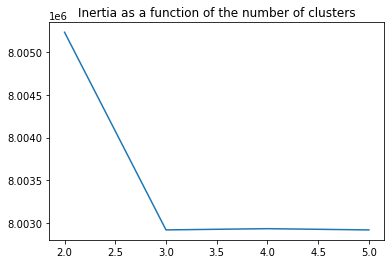

In [101]:

lk = []
l_inertia = []

for k in range(2, 6):
    print(k)
    kmeans = KMeans(n_clusters = 5)
    kmeans.fit(embedding)
    lk.append(k)
    l_inertia.append(kmeans.inertia_)

plt.plot(lk, l_inertia)
plt.title("Inertia as a function of the number of clusters")
print()

In [ ]:

lk = []
l_inertia = []

for k in range(2, 20):
    print(k)
    best_kmeans = None
    best_inertia = np.inf
    for _ in range(5):
        kmeans = MiniBatchKMeans(n_clusters = 5)
        kmeans.fit(embedding)
        if best_inertia > kmeans.inertia_:
            best_kmeans = kmeans
            best_inertia = kmeans.inertia_
    kmeans = best_kmeans
    lk.append(k)
    l_inertia.append(kmeans.inertia_)

plt.plot(lk, l_inertia)
plt.title("Inertia as a function of the number of clusters")
print()

In [71]:
kmeans.inertia_

8024690.141775528

In [104]:
X, y = make_blobs(100, 2, centers = 6)

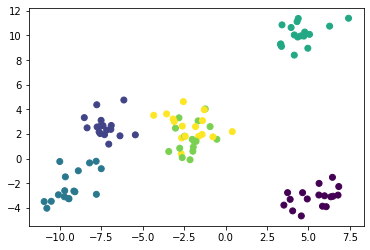

In [105]:
x1 = X[:,0]
x2 = X[:,1]

plt.scatter(x1, x2, c = y)

2
3
4
5
6
7
8
9



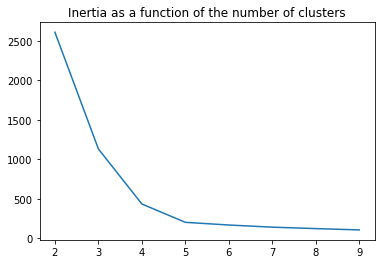

In [106]:
lk = []
l_inertia = []

for k in range(2, 10):
    print(k)
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(X)
    lk.append(k)
    l_inertia.append(kmeans.inertia_)

plt.plot(lk, l_inertia)
plt.title("Inertia as a function of the number of clusters")
print()

### Evaluate the clustering

To evaluate this clustering, we will use functions from 3.14.7 and compare the results against a random partition. Induced graph might be of interest.

In [112]:
G[2218957460]

AtlasView({2076469802: {}, 2164966972: {}, 2434321585: {}, 2310541675: {}, 2107787884: {}, 2231641062: {}, 2639943607: {}, 2216368757: {}, 2291719633: {}, 1526249137: {}, 2421072351: {}, 2141458738: {}, 2003942722: {}, 2112810119: {}, 2147736635: {}, 2165824847: {}})

In [113]:
G.number_of_nodes()

217801